---

# Happy, Sad, or Angry?


<img src="http://www.evanmarie.com/content/files/notebook_images/happysadangry_banner.png" width=800>


In [1]:
#@title Importing the Lovelies
%%capture
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!pip install nbdev
from fastbook import *
from fastai.vision.widgets import *
import nbdev
from fastai.vision import *
from pathlib import Path
import PIL

!pip install -q jmd_imagescraper
from jmd_imagescraper.core import * 
from jmd_imagescraper.imagecleaner import *

### ➢ Setting up the path where images will be saved

In [2]:
categories=['happy', 'sad', 'angry']
path = Path().cwd()/"faces"   # assigns path to current working directory

### ➢ Downloading 400 images of each facial expression
It took a lot of experimenting with the best search strings for getting the most images of actual human faces showing the three emotions rather than getting primarily emojis showing the emotions. I did happen to get a model 100% accurate on discerning emoji emotions. But that was not nearly as interesting to me as the challenge of classifying the emotions from human image data.

In [3]:
%%capture
duckduckgo_search(path,"happy","human smiling",max_results=400) # downloads 400 images of 'happy faces' and saves to happy folder
duckduckgo_search(path,"sad","human frowning",max_results=400) # downloads 400 images of 'sad faces' and saves to sad folder
duckduckgo_search(path,"angry","mad human",max_results=400) # downloads 400 images of 'angry faces' and saves to angry folder

In [4]:
face_images=get_image_files(path)
face_images

(#1200) [Path('/content/faces/sad/043_2c1f665f.jpg'),Path('/content/faces/sad/376_60aceeaa.jpg'),Path('/content/faces/sad/329_e0416c1b.jpg'),Path('/content/faces/sad/173_c938afbb.jpg'),Path('/content/faces/sad/167_61aa22ad.jpg'),Path('/content/faces/sad/306_6924868d.jpg'),Path('/content/faces/sad/062_90cd6994.jpg'),Path('/content/faces/sad/017_b700f3ae.jpg'),Path('/content/faces/sad/023_35a3fce6.jpg'),Path('/content/faces/sad/222_e55f96d4.jpg')...]

### ➢ Removing any failed downloads

In [5]:
failed_images_faces=verify_images(face_images)  # looks for files that arent images
failed_images_faces

(#0) []

In [6]:
failed_images_faces.map(Path.unlink);  # unlinks the failed files from the folder

In [7]:
face_types = 'happy','sad','angry'
path = Path('faces')

### ➢ Defining dataloaders and the splitter function for test-train splitting

In [8]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [9]:
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
blocks=(ImageBlock, CategoryBlock)
get_items=get_image_files
splitter=RandomSplitter(valid_pct=0.2, seed=42)
get_y=parent_label
item_tfms=Resize(128)
dls_faces = faces.dataloaders(path)

### ➢ Sample of images from one of the batches
As you can see, some of the data will need to be weeded out, as it would not only be completely useless in training the model, but it will greatly distort the accuracy.

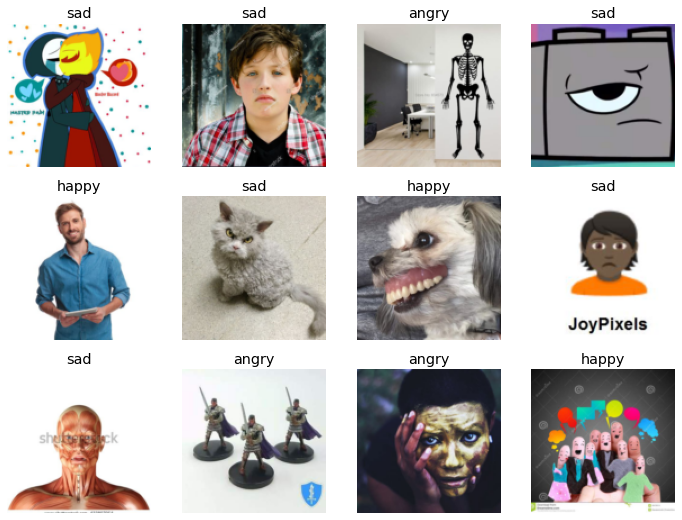

In [12]:
  dls_faces.valid.show_batch(max_n=12, nrows=3)

### Training Model

<br>

I am using data augmentation here, creating 4 "versions" of each photo which are slightly altered to help the model judge the classes / categories of facial expressions more accurately.

I have tried out a wide variety of pre-trained models for this project, and these three, Resnet 50, Resnet 34 and Resnet 101, have proven to be the most useful here. Each reaches a different level of accuracy at a different number of epochs of training. So I will choose the one that reaches the highest accuracy and train it as the final model at the ideal number of epochs.

In [13]:
faces = faces.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=4))
dls = faces.dataloaders(path)

### ➢ Resnet 50

In [14]:
learn_faces_resnet50 = vision_learner(dls, resnet50, metrics=accuracy)
learn_faces_resnet50.fine_tune(40)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.883796,1.649455,0.537500,00:15


epoch,train_loss,valid_loss,accuracy,time
0,1.713253,1.500839,0.604167,00:14
1,1.600686,1.266013,0.566667,00:13
2,1.511716,1.277781,0.604167,00:15
3,1.411794,1.115444,0.650000,00:17
4,1.353658,1.157303,0.616667,00:15
5,1.321333,0.903919,0.662500,00:14
6,1.271875,1.117477,0.629167,00:13
7,1.188697,0.995775,0.666667,00:14
8,1.120116,1.186529,0.658333,00:14
9,1.092767,1.210955,0.683333,00:14


### ➢ Exporting the first Resnet 50 trained model

In [ ]:
learn_faces_resnet50.export('faces_resenet50_78.pk1')

### ➢ Resnet 34

In [15]:
learn_faces_resnet34 = vision_learner(dls, resnet34, metrics=accuracy)
learn_faces_resnet34.fine_tune(40)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.768051,1.246687,0.587500,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.590860,1.056080,0.570833,00:10
1,1.537315,1.038045,0.570833,00:09
2,1.496346,1.021857,0.583333,00:11
3,1.428746,0.947524,0.595833,00:13
4,1.386289,0.883331,0.620833,00:11
5,1.348938,0.918316,0.650000,00:10
6,1.323364,0.883041,0.670833,00:10
7,1.298637,0.916929,0.666667,00:11
8,1.254509,0.977028,0.687500,00:10
9,1.210763,0.943669,0.700000,00:10


### ➢ Exporting the Resnet 34 trained model

In [ ]:
learn_faces_resnet34.export('faces_resenet34.pk1')

### ➢ Resnet 101

In [16]:
learn_faces_resnet101 = vision_learner(dls, resnet101, metrics=accuracy)
learn_faces_resnet101.fine_tune(40)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.783111,1.446296,0.595833,00:16


epoch,train_loss,valid_loss,accuracy,time
0,1.606528,1.319440,0.570833,00:21
1,1.482362,1.193370,0.600000,00:22
2,1.422865,1.134938,0.641667,00:23
3,1.363267,1.143495,0.633333,00:22
4,1.310734,1.260934,0.600000,00:22
5,1.255939,1.243073,0.591667,00:22
6,1.231061,1.126673,0.670833,00:22
7,1.218513,1.222914,0.641667,00:23
8,1.164778,1.202701,0.633333,00:22
9,1.113414,1.077255,0.637500,00:22


### ➢ Exporting the Resnet 101 trained model

In [17]:
learn_faces_resnet101.export('faces_resenet101.pk1')

### ➢ Confusion Matrices
Here are the confusion matrices from the three different models

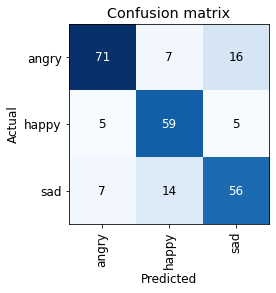

In [18]:
interp = ClassificationInterpretation.from_learner(learn_faces_resnet50)
interp.plot_confusion_matrix()

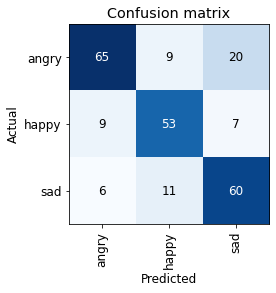

In [19]:
interp = ClassificationInterpretation.from_learner(learn_faces_resnet34)
interp.plot_confusion_matrix()

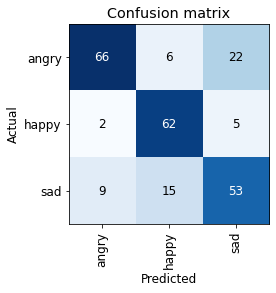

In [20]:
interp = ClassificationInterpretation.from_learner(learn_faces_resnet101)
interp.plot_confusion_matrix()

### **`plot_top_losses()`**

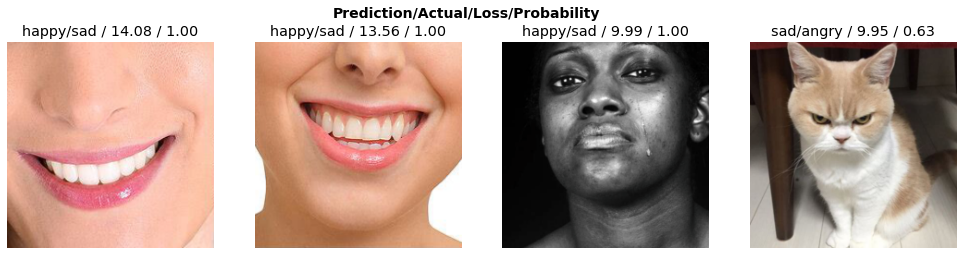

In [21]:
interp.plot_top_losses(4, nrows=1, figsize=(17,4))

### Clearning out the lesser quality data

`ImageClassifierCleaner()` organizes the images by highest loss so that we can clean out the ones that are mislabeled. Here, you can go and check that the images in the training and in the validation set are all correctly categorized, change ones that are miscategorized, and delete ones that are just plain wrong.

In [22]:
cleaner = ImageClassifierCleaner(learn_faces_resnet50)
cleaner

### ➢ Removing images marked for deletion

In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [24]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### ➢ Predictions


sad


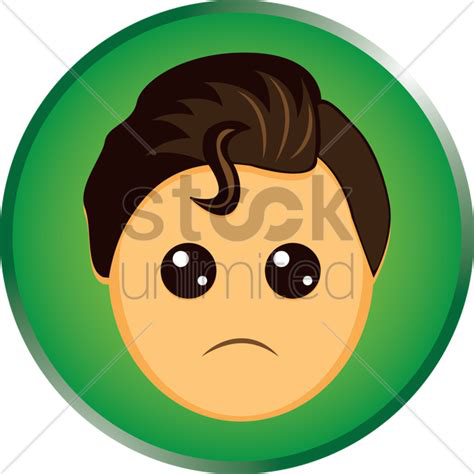

In [33]:
face_01 = get_image_files(path)[111]
print(learn_faces_resnet50.predict(face_01)[0])
img = PIL.Image.open(face_01)
img

happy


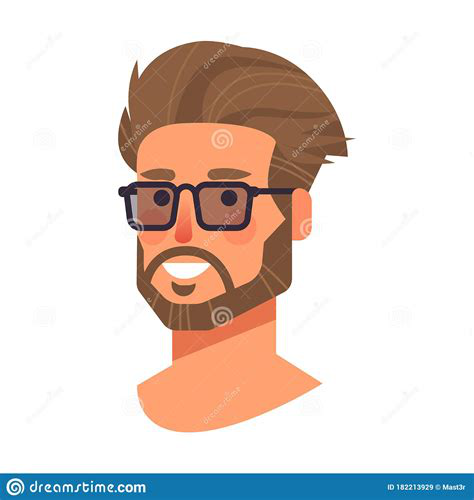

In [30]:
face_02 = get_image_files(path)[777]
print(learn_faces_resnet50.predict(face_02)[0])
img = PIL.Image.open(face_02)
img

happy


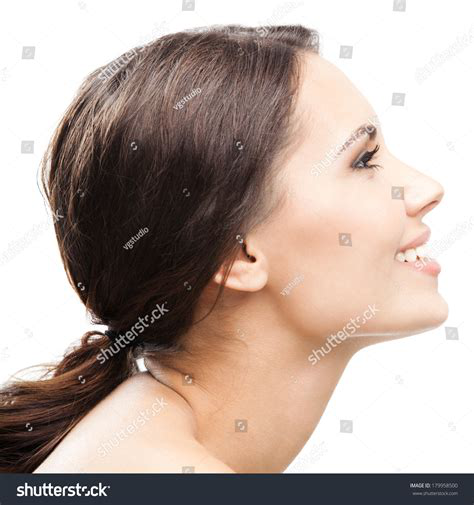

In [29]:
face_03 = get_image_files(path)[666]
print(learn_faces_resnet50.predict(face_03)[0])
img = PIL.Image.open(face_03)
img

happy


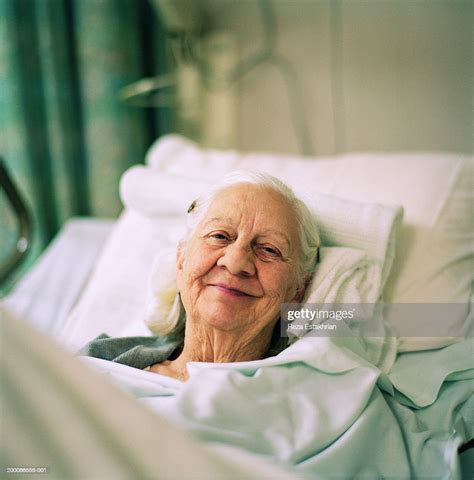

In [34]:
face_04 = get_image_files(path)[444]
print(learn_faces_resnet50.predict(face_04)[0])
img = PIL.Image.open(face_04)
img